This notebook contains examples of TextClustering model usage for Banking77 datasets.

In [44]:
import pandas as pd
import numpy as np

from omegaconf import OmegaConf

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from utils.data_utils import *
from text_clustering import TextClustering
from utils.evaluation_utils import evaluate_classic_clustering
from utils.training_and_visualisation import plot_losses

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

To load and split Banking or Demo datasets, you may use functions from ```utils/data_utils.py```. You need to place .csv file with texts (and, possibly, cluester markup) in ```BANKING_PATH``` directory. This directory should contain subdirectory ```embeds/``` with texts embeddings saved as a torch.Tensor of shape ```[n_texts, input_dim]```. 

To add a custom dataset, you need a dataframe containing texts (column 'text') and markup (columns 'cluster') and a tensor of embeddings. Make sure that ```len(dataframe) == embeds.shape[0]```.

In [2]:
BANKING_PATH = "data/banking77/"

data_all, clusters_all, embeds_t5_all = load_banking_data(BANKING_PATH)

NUM_CLUSTERS = 10

base_embeds, _, base_data, base_clusters = sample_banking_clusters(
    dataframe=data_all,
    raw_embeds=embeds_t5_all,
    cluster_num_list=np.linspace(0, NUM_CLUSTERS - 1, NUM_CLUSTERS)
)

INP_DIM = base_embeds.shape[1]

# Classic algorithms

To initialize a classic clustering model, you need to choose dimensionality reduction type (None, 'pca', 'umap', 'tsne' or 'pacmap'), number of components (aka ```feat_dim```), clustering type ('kmeans', 'gmm', 'hdbscan', 'mean_shift' or 'spectral') and its hyper-parameters (```min_samples``` and ```min_cluster_size``` for HDBSCAN; ```bandwidth``` for MeanShift).
Once TextClustering model with the necessary parameters is initialized, it can be fitted and evaluated in the following way.

In [6]:
model = TextClustering(
    n_clusters=NUM_CLUSTERS,
    inp_dim=INP_DIM,
    feat_dim=10,
    train_dataset=base_embeds,
    data_frame=base_data,
    kind="classic clustering",
    dim_reduction_type="umap",
    clustering_type="gmm",
    random_state=42
)

model.fit(base_embeds)
_, clusters = model.transform_and_cluster(base_embeds)

metrics = model.evaluate(use_true_clusters=True)

print(f"Dim red time: {model.times['dim_red']}")
print(f"Clust time: {model.times['clust']}")

silhouette_score: 0.0737999975681305
adjusted_rand_score: 0.6782
adjusted_mutual_info_score: 0.809
average_topic_coherence: 0.7979
Dim red time: 12.172766208648682
Clust time: 0.14461278915405273


To run a series of experiments with grid search and save results in a .csv file, you may use the following function defined in ```evaluation_utils.py```.

In [15]:
results_banking = evaluate_classic_clustering(
    dataset="banking",
    data_path=BANKING_PATH,
    num_clasters=3,
    dim_reduction_type_list=[None, "pca", "pacmap"],
    n_components_list=[None, 10, 50],
    clustering_type_list=["kmeans", "gmm", "hdbscan", "spectral"], # "mean_shift"
    random_state=42,
    min_samples_list=[5, 10],
    min_cluster_size_list=[10, 30, 60],
    bandwidth_list=[1.00, 1.50, 2.00],
    verbose=True,
    save_df=False
)

  0%|          | 0/36 [00:00<?, ?it/s]

dim_red: None, n_comp: None, clustering: kmeans


  3%|▎         | 1/36 [00:03<02:14,  3.83s/it]

silhouette_score: 0.13809999823570251
adjusted_rand_score: 0.9721
adjusted_mutual_info_score: 0.9557
average_topic_coherence: 0.7618
--------------------------------------------------------------------------------
  Dim reduction Clustering Best params  Adjusted Rand  Adjusted Mutual Info   
0             -     kmeans           -       0.972135                0.9557  \

   Silhouette Score  Avg topic coherence  Dim red time, sec   
0          0.138146             0.761817                0.0  \

   Clustering time, sec  
0              0.048869  
dim_red: None, n_comp: None, clustering: gmm


  6%|▌         | 2/36 [00:09<02:54,  5.12s/it]

silhouette_score: 0.13809999823570251
adjusted_rand_score: 0.9721
adjusted_mutual_info_score: 0.9557
average_topic_coherence: 0.7914
--------------------------------------------------------------------------------
  Dim reduction Clustering Best params  Adjusted Rand  Adjusted Mutual Info   
0             -        gmm           -       0.972135                0.9557  \

   Silhouette Score  Avg topic coherence  Dim red time, sec   
0          0.138146             0.791376                0.0  \

   Clustering time, sec  
0              0.970591  
dim_red: None, n_comp: None, clustering: hdbscan
Grid search for HDBSCAN parameters



  0%|          | 0/6 [00:00<?, ?it/s]

min_samples: 5, min_cluster_size: 10



 17%|█▋        | 1/6 [00:06<00:34,  6.81s/it]

silhouette_score: -0.04439999908208847
adjusted_rand_score: 0.1016
adjusted_mutual_info_score: 0.3382
average_topic_coherence: 0.7753
min_samples: 5, min_cluster_size: 30



 33%|███▎      | 2/6 [00:11<00:23,  5.84s/it]

silhouette_score: -0.0032999999821186066
adjusted_rand_score: 0.216
adjusted_mutual_info_score: 0.4331
average_topic_coherence: 0.8559
min_samples: 5, min_cluster_size: 60



 50%|█████     | 3/6 [00:16<00:16,  5.42s/it]

silhouette_score: -0.0032999999821186066
adjusted_rand_score: 0.216
adjusted_mutual_info_score: 0.4331
average_topic_coherence: 0.8559
min_samples: 10, min_cluster_size: 10



 67%|██████▋   | 4/6 [00:21<00:10,  5.20s/it]

silhouette_score: -0.04450000077486038
adjusted_rand_score: 0.1166
adjusted_mutual_info_score: 0.361
average_topic_coherence: 0.8618
min_samples: 10, min_cluster_size: 30



 83%|████████▎ | 5/6 [00:26<00:05,  5.14s/it]

silhouette_score: 0.012400000356137753
adjusted_rand_score: 0.1302
adjusted_mutual_info_score: 0.2781
average_topic_coherence: 0.8088
min_samples: 10, min_cluster_size: 60



  8%|▊         | 3/36 [00:41<09:32, 17.36s/it]

silhouette_score: 0.012400000356137753
adjusted_rand_score: 0.1302
adjusted_mutual_info_score: 0.2781
average_topic_coherence: 0.8088
silhouette_score: 0.012400000356137753
adjusted_rand_score: 0.1302
adjusted_mutual_info_score: 0.2781
average_topic_coherence: 0.8088
--------------------------------------------------------------------------------
  Dim reduction Clustering              Best params  Adjusted Rand   
0             -    hdbscan  min_s = 5 min_cl_s = 30       0.216036  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.433117         -0.003289             0.855862  \

   Dim red time, sec  Clustering time, sec  
0                0.0              0.816192  
dim_red: None, n_comp: None, clustering: spectral


 11%|█         | 4/36 [00:46<06:35, 12.35s/it]

silhouette_score: 0.13079999387264252
adjusted_rand_score: 0.8111
adjusted_mutual_info_score: 0.7803
average_topic_coherence: 0.597
--------------------------------------------------------------------------------
  Dim reduction Clustering Best params  Adjusted Rand  Adjusted Mutual Info   
0             -   spectral           -       0.811082              0.780286  \

   Silhouette Score  Avg topic coherence  Dim red time, sec   
0          0.130804             0.596958                0.0  \

   Clustering time, sec  
0              0.207996  
dim_red: pca, n_comp: 10, clustering: kmeans


 47%|████▋     | 17/36 [00:51<00:34,  1.79s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9664
adjusted_mutual_info_score: 0.9489
average_topic_coherence: 0.7957
--------------------------------------------------------------------------------
        Dim reduction Clustering Best params  Adjusted Rand   
0  pca, feat_dim = 10     kmeans           -       0.966351  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.948941          0.138232             0.795714  \

   Dim red time, sec  Clustering time, sec  
0           0.308976              0.016956  
dim_red: pca, n_comp: 10, clustering: gmm


 50%|█████     | 18/36 [00:54<00:35,  1.96s/it]

silhouette_score: 0.13840000331401825
adjusted_rand_score: 1.0
adjusted_mutual_info_score: 1.0
average_topic_coherence: 0.8051
--------------------------------------------------------------------------------
        Dim reduction Clustering Best params  Adjusted Rand   
0  pca, feat_dim = 10        gmm           -            1.0  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0                   1.0          0.138433             0.805134  \

   Dim red time, sec  Clustering time, sec  
0           0.040884               0.02851  
dim_red: pca, n_comp: 10, clustering: hdbscan
Grid search for HDBSCAN parameters



  0%|          | 0/6 [00:00<?, ?it/s]

min_samples: 5, min_cluster_size: 10



 17%|█▋        | 1/6 [00:03<00:19,  4.00s/it]

silhouette_score: 0.0917000025510788
adjusted_rand_score: 0.6476
adjusted_mutual_info_score: 0.7034
average_topic_coherence: 0.7408
min_samples: 5, min_cluster_size: 30



 33%|███▎      | 2/6 [00:07<00:14,  3.58s/it]

silhouette_score: 0.0917000025510788
adjusted_rand_score: 0.6476
adjusted_mutual_info_score: 0.7034
average_topic_coherence: 0.7408
min_samples: 5, min_cluster_size: 60



 50%|█████     | 3/6 [00:11<00:11,  3.77s/it]

silhouette_score: 0.0917000025510788
adjusted_rand_score: 0.6476
adjusted_mutual_info_score: 0.7034
average_topic_coherence: 0.7408
min_samples: 10, min_cluster_size: 10



 67%|██████▋   | 4/6 [00:15<00:07,  3.88s/it]

silhouette_score: 0.04149999842047691
adjusted_rand_score: 0.407
adjusted_mutual_info_score: 0.5557
average_topic_coherence: 0.8815
min_samples: 10, min_cluster_size: 30



 83%|████████▎ | 5/6 [00:19<00:04,  4.01s/it]

silhouette_score: 0.06759999692440033
adjusted_rand_score: 0.5028
adjusted_mutual_info_score: 0.6072
average_topic_coherence: 0.8241
min_samples: 10, min_cluster_size: 60



 53%|█████▎    | 19/36 [01:18<01:13,  4.35s/it]

silhouette_score: 0.06710000336170197
adjusted_rand_score: 0.4973
adjusted_mutual_info_score: 0.604
average_topic_coherence: 0.8305
silhouette_score: 0.06710000336170197
adjusted_rand_score: 0.4973
adjusted_mutual_info_score: 0.604
average_topic_coherence: 0.8305
--------------------------------------------------------------------------------
        Dim reduction Clustering              Best params  Adjusted Rand   
0  pca, feat_dim = 10    hdbscan  min_s = 5 min_cl_s = 10         0.6476  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.703368          0.091715             0.740803  \

   Dim red time, sec  Clustering time, sec  
0           0.036898              0.019948  
dim_red: pca, n_comp: 10, clustering: spectral


 56%|█████▌    | 20/36 [01:22<01:09,  4.37s/it]

silhouette_score: 0.13510000705718994
adjusted_rand_score: 0.8901
adjusted_mutual_info_score: 0.847
average_topic_coherence: 0.7365
--------------------------------------------------------------------------------
        Dim reduction Clustering Best params  Adjusted Rand   
0  pca, feat_dim = 10   spectral           -       0.890103  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0               0.84696          0.135088             0.736461  \

   Dim red time, sec  Clustering time, sec  
0           0.042946              0.174533  
dim_red: pca, n_comp: 50, clustering: kmeans


 58%|█████▊    | 21/36 [01:27<01:05,  4.39s/it]

silhouette_score: 0.10790000110864639
adjusted_rand_score: 0.3818
adjusted_mutual_info_score: 0.5173
average_topic_coherence: 0.7913
--------------------------------------------------------------------------------
        Dim reduction Clustering Best params  Adjusted Rand   
0  pca, feat_dim = 50     kmeans           -       0.381767  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.517257          0.107922              0.79134  \

   Dim red time, sec  Clustering time, sec  
0            0.31178               0.01895  
dim_red: pca, n_comp: 50, clustering: gmm


 61%|██████    | 22/36 [01:30<00:59,  4.24s/it]

silhouette_score: 0.10369999706745148
adjusted_rand_score: 0.4
adjusted_mutual_info_score: 0.5431
average_topic_coherence: 0.8052
--------------------------------------------------------------------------------
        Dim reduction Clustering Best params  Adjusted Rand   
0  pca, feat_dim = 50        gmm           -       0.400033  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.543098          0.103718             0.805242  \

   Dim red time, sec  Clustering time, sec  
0           0.088748               0.04887  
dim_red: pca, n_comp: 50, clustering: hdbscan
Grid search for HDBSCAN parameters



  0%|          | 0/6 [00:00<?, ?it/s]

min_samples: 5, min_cluster_size: 10



 17%|█▋        | 1/6 [00:03<00:17,  3.50s/it]

silhouette_score: 0.053700000047683716
adjusted_rand_score: 0.4434
adjusted_mutual_info_score: 0.5781
average_topic_coherence: 0.8264
min_samples: 5, min_cluster_size: 30



 33%|███▎      | 2/6 [00:07<00:15,  3.80s/it]

silhouette_score: 0.047200001776218414
adjusted_rand_score: 0.4125
adjusted_mutual_info_score: 0.5616
average_topic_coherence: 0.8332
min_samples: 5, min_cluster_size: 60



 50%|█████     | 3/6 [00:10<00:10,  3.58s/it]

silhouette_score: 0.05169999971985817
adjusted_rand_score: 0.4391
adjusted_mutual_info_score: 0.5758
average_topic_coherence: 0.8247
min_samples: 10, min_cluster_size: 10



 67%|██████▋   | 4/6 [00:14<00:07,  3.60s/it]

silhouette_score: 0.01769999973475933
adjusted_rand_score: 0.2801
adjusted_mutual_info_score: 0.4858
average_topic_coherence: 0.8035
min_samples: 10, min_cluster_size: 30



 83%|████████▎ | 5/6 [00:17<00:03,  3.57s/it]

silhouette_score: 0.016699999570846558
adjusted_rand_score: 0.2753
adjusted_mutual_info_score: 0.4759
average_topic_coherence: 0.8046
min_samples: 10, min_cluster_size: 60



 64%|██████▍   | 23/36 [01:54<01:49,  8.40s/it]

silhouette_score: 0.015799999237060547
adjusted_rand_score: 0.2737
adjusted_mutual_info_score: 0.4752
average_topic_coherence: 0.8011
silhouette_score: 0.015799999237060547
adjusted_rand_score: 0.2737
adjusted_mutual_info_score: 0.4752
average_topic_coherence: 0.8011
--------------------------------------------------------------------------------
        Dim reduction Clustering              Best params  Adjusted Rand   
0  pca, feat_dim = 50    hdbscan  min_s = 5 min_cl_s = 10        0.44345  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.578055          0.053659              0.82636  \

   Dim red time, sec  Clustering time, sec  
0           0.128791              0.050826  
dim_red: pca, n_comp: 50, clustering: spectral


 67%|██████▋   | 24/36 [01:58<01:28,  7.37s/it]

silhouette_score: 0.13040000200271606
adjusted_rand_score: 0.8118
adjusted_mutual_info_score: 0.7731
average_topic_coherence: 0.5788
--------------------------------------------------------------------------------
        Dim reduction Clustering Best params  Adjusted Rand   
0  pca, feat_dim = 50   spectral           -       0.811813  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.773068          0.130414             0.578772  \

   Dim red time, sec  Clustering time, sec  
0           0.081023              0.118683  
dim_red: pacmap, n_comp: 10, clustering: kmeans


 81%|████████  | 29/36 [02:05<00:25,  3.70s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering Best params  Adjusted Rand   
0  pacmap, feat_dim = 10     kmeans           -       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195             0.805719  \

   Dim red time, sec  Clustering time, sec  
0           1.433463              1.011447  
dim_red: pacmap, n_comp: 10, clustering: gmm


 83%|████████▎ | 30/36 [02:12<00:25,  4.21s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering Best params  Adjusted Rand   
0  pacmap, feat_dim = 10        gmm           -       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195             0.805719  \

   Dim red time, sec  Clustering time, sec  
0            0.93431              1.032271  
dim_red: pacmap, n_comp: 10, clustering: hdbscan
Grid search for HDBSCAN parameters



  0%|          | 0/6 [00:00<?, ?it/s]

min_samples: 5, min_cluster_size: 10



 17%|█▋        | 1/6 [00:06<00:33,  6.80s/it]

silhouette_score: 0.0949999988079071
adjusted_rand_score: 0.8536
adjusted_mutual_info_score: 0.8108
average_topic_coherence: 0.727
min_samples: 5, min_cluster_size: 30



 33%|███▎      | 2/6 [00:13<00:26,  6.52s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 5, min_cluster_size: 60



 50%|█████     | 3/6 [00:19<00:19,  6.61s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 10, min_cluster_size: 10



 67%|██████▋   | 4/6 [00:26<00:13,  6.56s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 10, min_cluster_size: 30



 83%|████████▎ | 5/6 [00:32<00:06,  6.44s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 10, min_cluster_size: 60



 86%|████████▌ | 31/36 [02:51<00:51, 10.38s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering              Best params  Adjusted Rand   
0  pacmap, feat_dim = 10    hdbscan  min_s = 5 min_cl_s = 30       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195             0.805719  \

   Dim red time, sec  Clustering time, sec  
0           0.906801              1.024348  
dim_red: pacmap, n_comp: 10, clustering: spectral


 89%|████████▉ | 32/36 [02:58<00:38,  9.69s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8301
--------------------------------------------------------------------------------
           Dim reduction Clustering Best params  Adjusted Rand   
0  pacmap, feat_dim = 10   spectral           -       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195              0.83006  \

   Dim red time, sec  Clustering time, sec  
0           1.113462               1.03625  
dim_red: pacmap, n_comp: 50, clustering: kmeans


 92%|█████████▏| 33/36 [03:09<00:29,  9.99s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering Best params  Adjusted Rand   
0  pacmap, feat_dim = 50     kmeans           -       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195             0.805719  \

   Dim red time, sec  Clustering time, sec  
0           2.280591              2.282292  
dim_red: pacmap, n_comp: 50, clustering: gmm


 94%|█████████▍| 34/36 [03:20<00:20, 10.16s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering Best params  Adjusted Rand   
0  pacmap, feat_dim = 50        gmm           -       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195             0.805719  \

   Dim red time, sec  Clustering time, sec  
0           2.357454              2.444662  
dim_red: pacmap, n_comp: 50, clustering: hdbscan
Grid search for HDBSCAN parameters



  0%|          | 0/6 [00:00<?, ?it/s]

min_samples: 5, min_cluster_size: 10



 17%|█▋        | 1/6 [00:10<00:51, 10.25s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 5, min_cluster_size: 30



 33%|███▎      | 2/6 [00:20<00:41, 10.32s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 5, min_cluster_size: 60



 50%|█████     | 3/6 [00:31<00:31, 10.53s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 10, min_cluster_size: 10



 67%|██████▋   | 4/6 [00:41<00:20, 10.50s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 10, min_cluster_size: 30



 83%|████████▎ | 5/6 [00:52<00:10, 10.39s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
min_samples: 10, min_cluster_size: 60



 97%|█████████▋| 35/36 [04:22<00:23, 23.61s/it]

silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
silhouette_score: 0.13819999992847443
adjusted_rand_score: 0.9882
adjusted_mutual_info_score: 0.979
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering              Best params  Adjusted Rand   
0  pacmap, feat_dim = 50    hdbscan  min_s = 5 min_cl_s = 10       0.988227  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.978954          0.138195             0.805719  \

   Dim red time, sec  Clustering time, sec  
0            2.46875              2.124847  
dim_red: pacmap, n_comp: 50, clustering: spectral


100%|██████████| 36/36 [04:34<00:00,  7.62s/it]

silhouette_score: 0.10890000313520432
adjusted_rand_score: 0.7596
adjusted_mutual_info_score: 0.787
average_topic_coherence: 0.8057
--------------------------------------------------------------------------------
           Dim reduction Clustering Best params  Adjusted Rand   
0  pacmap, feat_dim = 50   spectral           -        0.75962  \

   Adjusted Mutual Info  Silhouette Score  Avg topic coherence   
0              0.786962          0.108898             0.805719  \

   Dim red time, sec  Clustering time, sec  
0           2.296216              2.502897  


In [16]:
results_banking

,Dim reduction,Clustering,Best params,Adjusted Rand,Adjusted Mutual Info,Silhouette Score,Avg topic coherence,"Dim red time, sec","Clustering time, sec"
0,-,kmeans,-,0.9721,0.9557,0.1381,0.7618,0.0000,0.0489
1,-,gmm,-,0.9721,0.9557,0.1381,0.7914,0.0000,0.9706
2,-,hdbscan,min_s = 5 min_cl_s = 30,0.2160,0.4331,-0.0033,0.8559,0.0000,0.8162
3,-,spectral,-,0.8111,0.7803,0.1308,0.5970,0.0000,0.2080
4,"pca, feat_dim = 10",kmeans,-,0.9664,0.9489,0.1382,0.7957,0.3090,0.0170
5,"pca, feat_dim = 10",gmm,-,1.0000,1.0000,0.1384,0.8051,0.0409,0.0285
6,"pca, feat_dim = 10",hdbscan,min_s = 5 min_cl_s = 10,0.6476,0.7034,0.0917,0.7408,0.0369,0.0199
7,"pca, feat_dim = 10",spectral,-,0.8901,0.8470,0.1351,0.7365,0.0429,0.1745
8,"pca, feat_dim = 50",kmeans,-,0.3818,0.5173,0.1079,0.7913,0.3118,0.0189
9,"pca, feat_dim = 50",gmm,-,0.4000,0.5431,0.1037,0.8052,0.0887,0.0489


# Deep clustering

To train a deep clustering models, the same interface can be used. 

In [28]:
model = TextClustering(
    n_clusters=NUM_CLUSTERS,
    inp_dim=INP_DIM,
    feat_dim=10,
    train_dataset=base_embeds,
    data_frame=base_data,
    kind="deep clustering",
    deep_model_type="DCN",
    random_state=42
)

losses1, losses2 = model.fit(base_embeds)
_, clusters = model.transform_and_cluster(base_embeds)

metrics = model.evaluate(use_true_clusters=True)

print(f"Dim red time: {model.times['dim_red']}")
print(f"Clust time: {model.times['clust']}")

Phase 1: train embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

Phase 2: train clusters


  0%|          | 0/8 [00:00<?, ?it/s]

silhouette_score: 0.07209999859333038
adjusted_rand_score: 0.5876
adjusted_mutual_info_score: 0.7177
average_topic_coherence: 0.7422
Dim red time: 132.71807289123535
Clust time: 510.8079090118408


You can also visualize the training process during both phases in one line:

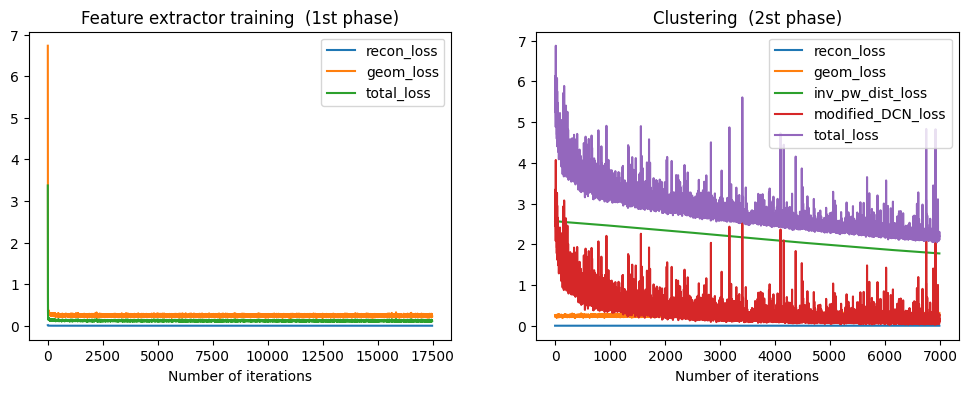

In [45]:
plot_losses([losses1, losses2], ["Feature extractor training  (1st phase)", "Clustering  (2st phase)"])

Or draw the graphs separately:

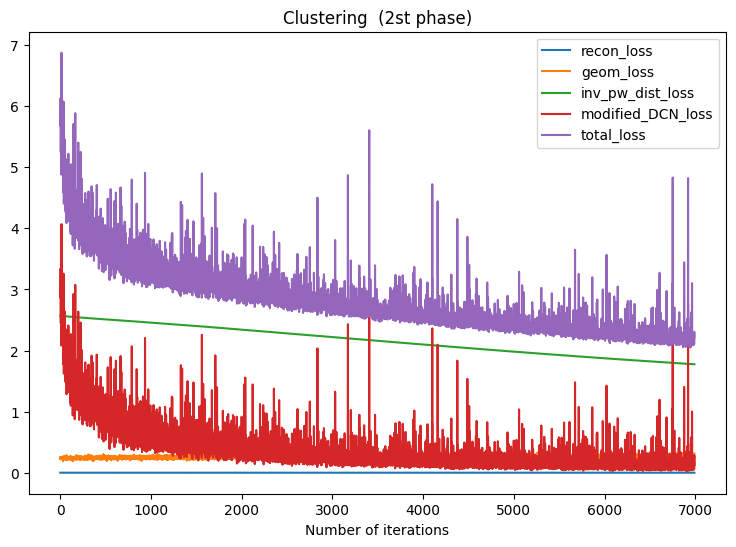

In [47]:
plot_losses(losses2, "Clustering  (2st phase)")

For deep clustering models the visualisation of clusters is available:

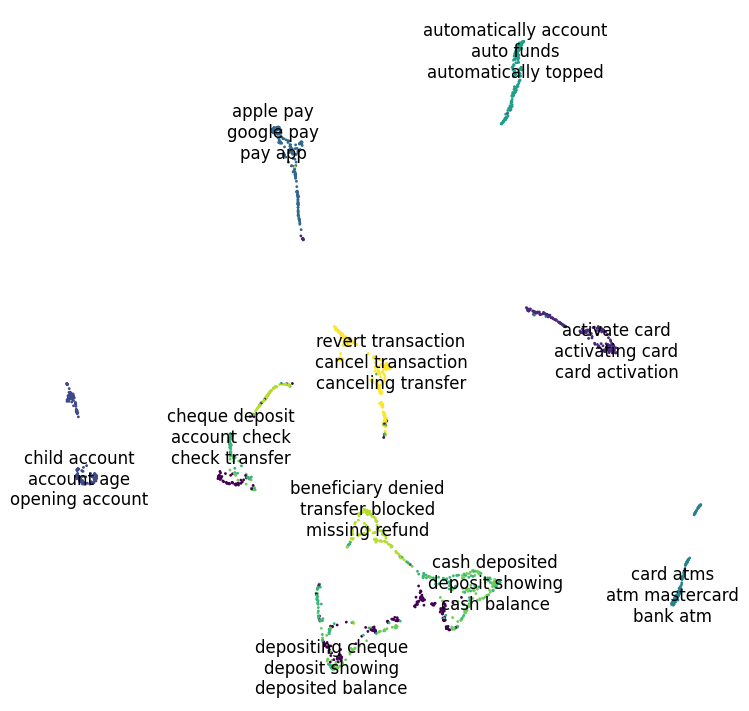

In [31]:
model.visualize_2d(base_embeds, base_clusters)

# Contrastive Hierarchical Clustering

CoHiClust model can be trained using the same TextClustering wrapper. For this model, you should use OmegaConf configuration file (they are available for Banking and Demo datasets or you can create your own). 

In [17]:
dataset_name = "banking" + str(NUM_CLUSTERS)
cohiclust_cfg = OmegaConf.load(f'cfg/{dataset_name}.yaml')
cohiclust_cfg

{'model': {'name': 'custom', 'inp_dim': 1024, 'out_dim': 128, 'drop_prob': 0.25, 'linear_dims_list': [2048, 2048, 1024]}, 'dataset': {'dataset_name': 'banking10', 'number_classes': 5, 'n_neighb': 5}, 'tree': {'tree_level': 4}, 'simclr': {'temperature': 0.5, 'k': 10, 'feature_dim_projection_head': 128}, 'training': {'epochs': 50, 'batch_size': 64, 'pretraining_epochs': 20, 'start_pruning_epochs': 30, 'leaves_to_prune': 6}}

In [18]:
model = TextClustering(
    n_clusters=NUM_CLUSTERS,
    inp_dim=INP_DIM,
    train_dataset=base_embeds,
    data_frame=base_data,
    cohiclust_cfg=cohiclust_cfg,
    feat_dim=10,
    kind="cohiclust",
    random_state=42
)

model.fit(base_embeds)
_, clusters = model.transform_and_cluster(base_embeds)

metrics = model.evaluate(use_true_clusters=True)

print(f"Dim red time: {model.times['dim_red']}")
print(f"Clust time: {model.times['clust']}")

Computing approximate KNN matrix
Computing approximate KNN matrix
Computing approximate KNN matrix


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

silhouette_score: 0.03229999914765358
adjusted_rand_score: 0.5134
adjusted_mutual_info_score: 0.6694
average_topic_coherence: 0.6941
Dim red time: 0
Clust time: 765.1120226383209
